# Sampling and calculating observables
## Generate new samples

Firstly, to generate meaningful data, an RBM needs to be trained. Please refer to the tutorials 1 and 2 on training an RBM-based Neural-Network-State if doing so using QuCumber is unclear. A Neural-Network-State (`nn_state`) of a positive-real wavefunction describing a transverse-field Ising model (TFIM) with 10 sites has already been trained in the first tutorial, with the parameters of the machine saved here as `saved_params.pt`. The `autoload` function can be employed here to instantiate the corresponding `PositiveWaveFunction` object from the saved `nn_state` parameters.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import qucumber
from qucumber.nn_states import PositiveWaveFunction, DensityMatrix
from qucumber.observables import ObservableBase
from qucumber.observables.pauli import flip_spin
from qucumber.utils import cplx

from quantum_ising_chain import TFIMChainEnergy, Convergence

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)
nn_state = PositiveWaveFunction.autoload("saved_params.pt", gpu=False)

A `PositiveWaveFunction` object has a property called `sample` that allows us to sample the learned distribution of TFIM chains. The it takes the following arguments (along with a few others which are not relevant for our purposes):

1. `k`: the number of Gibbs steps to perform to generate the new samples. Increasing this number will produce samples closer to the learned distribution, but will require more computation.
2. `num_samples`: the number of new data points to be generated

In [2]:
new_samples = nn_state.sample(k=100, num_samples=10000)
print(new_samples)

tensor([[1., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)


### Magnetization

With the newly generated samples, the user can now easily calculate observables that do not require any information associated with the wavefunction and hence the `nn_state`. These are observables which are diagonal in the computational (Pauli Z) basis. A great example of this is the magnetization (in the Z direction). To calculate the magnetization, the newly-generated samples must be converted to $\pm$ 1 from 1 and 0, respectively. The function below does the trick.

In [3]:
def to_pm1(samples):
    return samples.mul(2.0).sub(1.0)

Now, the (absolute) magnetization in the Z-direction is calculated as follows.

In [4]:
def Magnetization(samples):
    return to_pm1(samples).mean(1).abs().mean()


magnetization = Magnetization(new_samples).item()

print("Magnetization = %.5f" % magnetization)

Magnetization = 0.55752


The exact value for the magnetization is 0.5610. 

The magnetization and the newly-generated samples can also be saved to a pickle file along with the `nn_state` parameters in the *PositiveWaveFunction* object.

In [5]:
nn_state.save(
    "saved_params_and_new_data.pt",
    metadata={"samples": new_samples, "magnetization": magnetization},
)

The `metadata` argument in the `save` function takes in a dictionary of data that you would like to save alongside the `nn_state` parameters.

## Calculate an observable using the *Observable* module

### Magnetization (again)

QuCumber provides the `Observable` module to simplify estimation of expectations and variances of observables in memory efficient ways. To start off, we'll repeat the above example using the `SigmaZ` Observable module provided with QuCumber.

In [6]:
from qucumber.observables import SigmaZ

We'll compute the absolute magnetization again, for the sake of comparison with the previous example. We want to use the samples drawn earlier to perform this estimate, so we use the `statistics_from_samples` function:

In [7]:
sz = SigmaZ(absolute=True)
sz.statistics_from_samples(nn_state, new_samples)

{'mean': 0.5575200000000005,
 'variance': 0.09791724132414,
 'std_error': 0.0031291730748576373}

With this function we get the variance and standard error for free. Now you may be asking: "That's not too difficult, I could have computed those myself!". The power of the `Observable` module comes from the fact that it simplifies estimation of these values over a large number of samples. The `statistics` function computes these statistics by generating the samples internally. Let's see it in action:

In [8]:
%time sz.statistics(nn_state, num_samples=10000, burn_in=100)  
# just think of burn_in as being equivalent to k for now

CPU times: user 1.49 s, sys: 17.9 ms, total: 1.51 s
Wall time: 448 ms


{'mean': 0.5534800000000003,
 'variance': 0.09726161576157935,
 'std_error': 0.0031186794603097535}

Let's consider what is taking place under the hood at the moment. The `statistics` function is drawing 10000 samples from the given `nn_state`, and cycling it through the visible and hidden layers for 100 Block Gibbs steps before computing the statistics. This means that, at any given time it has to hold a matrix with 10000 rows and 10 (the number of lattice sites) columns in memory, which becomes infeasible for large lattices or if we want to use more samples to bring our standard error down. To bypass this issue, the `statistics` function allows us to specify the number of Markov Chains to evolve using the `nn_state`, and will sample from these chains multiple times to produce enough samples. It takes the following arguments:

- `num_samples`: the number of samples to generate internally
- `num_chains`: the number of Markov chains to run in parallel (default = 0, meaning `num_chains` = `num_samples`)
- `burn_in`: the number of Gibbs steps to perform before recording any samples (default = 1000)
- `steps`: the number of Gibbs steps to perform between each sample; increase this to reduce the autocorrelation between samples (default = 1)

The `statistics` function will also return a dictionary containing the mean, standard error (of the mean) and the variance with the keys `mean`, `std_error` and `variance`, respectively.

In [9]:
%time sz.statistics(nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2)

CPU times: user 298 ms, sys: 3.7 ms, total: 302 ms
Wall time: 78 ms


{'mean': 0.55116,
 'variance': 0.09716837123712346,
 'std_error': 0.003117184165831776}

In addition to using less memory (since the matrix held in memory is now of size `num_chains` x `num_sites` = 1000 x 10), using fewer chains also produced a decent speed boost! Next, we'll try increasing the total number of drawn samples:

In [10]:
sz.statistics(nn_state, num_samples=int(1e7), num_chains=1000, burn_in=100, steps=2)

{'mean': 0.5505669799999965,
 'variance': 0.09800984633466432,
 'std_error': 9.899992239121418e-05}

Note how much we reduced our standard error just by increasing the number of drawn samples. Finally, we can also draw samples of measurements **of the observable** using the `sample` function:

In [11]:
sz.sample(nn_state, k=100, num_samples=50)

tensor([0.6000, 0.2000, 0.0000, 0.4000, 0.6000, 0.8000, 0.6000, 0.2000, 0.2000,
        1.0000, 0.6000, 0.6000, 0.8000, 0.4000, 0.2000, 0.2000, 0.2000, 0.8000,
        0.6000, 0.2000, 0.2000, 0.8000, 0.6000, 0.6000, 0.8000, 1.0000, 0.4000,
        1.0000, 0.6000, 0.2000, 0.0000, 0.0000, 1.0000, 1.0000, 0.6000, 0.6000,
        0.2000, 1.0000, 0.2000, 1.0000, 0.8000, 0.0000, 0.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.2000, 0.4000, 0.6000], dtype=torch.float64)

Note that this function does not perform any fancy sampling tricks like `statistics` and is therefore susceptible to "Out of Memory" errors.

### TFIM Energy
Some observables cannot be computed directly from samples, but instead depend on the `nn_state` as previously mentioned. For example, the magnetization of the TFIM simply depends on the samples the user gives as input. While we did provide the `nn_state` as an argument when calling `statistics_from_samples`, `SigmaZ` ignores it. The TFIM energy, on the other hand, is much more complicated. Consider the TFIM Hamiltonian:

$$H = -J\sum_i \sigma_i^z \sigma_{i+1}^z - h\sum_i \sigma_i^x$$

As our `nn_state` was trained in the Z-basis, the off-diagonal transverse-field term is impossible to compute just from the samples; we need to know the value of the wavefunction for each sample as well. An example for the computation of the energy is provided in the python file `quantum_ising_chain.py`, which takes advantage of QuCumber's `Observable` module.

`quantum_ising_chain.py` comprises of a class that computes the energy of a TFIM (`TFIMChainEnergy`) that inherits properties from the `Observable` module. To instantiate a `TFIMChainEnergy` object, the $\frac{h}{J}$ value must be specified. The trained `nn_state` parameters are from the first tutorial, where the example data was from the TFIM with 10 sites at its critical point ($\frac{h}{J}=1$). 

In [12]:
h = 1

tfim_energy = TFIMChainEnergy(h)

To go ahead and calculate the mean energy and its standard error from the previously generated samples from this tutorial (`new_samples`), the `statistics_from_samples` function in the `Observable` module is called upon.

In [13]:
energy_stats = tfim_energy.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % energy_stats["mean"], "+/- %.4f" % energy_stats["std_error"])
print("Variance: %.4f" % energy_stats["variance"])

Mean: -1.2353 +/- 0.0005
Variance: 0.0022


The exact value for the energy is -1.2381. 

To illustrate how quickly the energy converges as a function of the sampling step (i.e. the number of Gibbs steps to perform to generate a new batch of samples), `steps`, the `Convergence` function in `quantum_ising_chain.py` will do the trick. `Convergence` creates a batch of random samples initially, which is then used to generate a new batch of samples from the `nn_state`. The TFIM energy will be calculated at every Gibbs step. Note that this function is not available in the QuCumber API; it is only used here as an illustrative example.

Text(0, 0.5, '% Error in Energy')

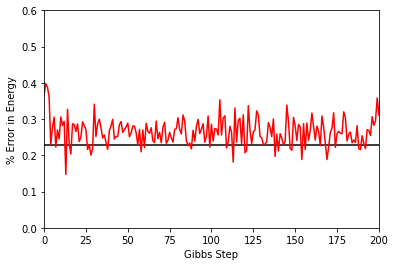

In [14]:
steps = 200
num_samples = 10000

dict_observables = Convergence(nn_state, tfim_energy, num_samples, steps)

energy = dict_observables["energies"]
err_energy = dict_observables["error"]

step = np.arange(steps + 1)

E0 = -1.2381

ax = plt.axes()
ax.plot(step, abs((E0 - energy) / E0) * 100, color="red")
ax.hlines(abs((E0 - energy_stats["mean"]) / E0) * 100, 0, 200, color="black")
ax.set_xlim(0, steps)
ax.set_ylim(0, 0.6)
ax.set_xlabel("Gibbs Step")
ax.set_ylabel("% Error in Energy")

One can see a brief transient period in the magnetization observable, before the state of the machine "warms up" to equilibrium (this explains the `burn_in` argument we saw earlier).  After that, the values fluctuate around the estimated mean (the horizontal black line).

### Combining observables

One may also add / subtract and multiply observables with each other or with real numbers. To illustrate this, we will build an alternative implementation of the TFIM energy observable. First, we will introduce the built-in `NeighbourInteraction` observable:

In [15]:
from qucumber.observables import NeighbourInteraction

The TFIM chain we trained the `nn_state` on did not have periodic boundary conditions, so `periodic_bcs=False`.
Meanwhile, `c` specifies the distance between interacting spins, that is, a given site will only interact with a site `c` places away from itself; we set this to 1 as the TFIM chain has nearest-neighbour interactions.

In [16]:
nn_inter = NeighbourInteraction(periodic_bcs=False, c=1)

Next, we need the `SigmaX` observable, which computes the magnetization in the X-direction:

In [17]:
from qucumber.observables import SigmaX

Next, we build the Hamiltonian, setting $h = J = 1$:

In [18]:
h = J = 1
sx = SigmaX()
tfim = -J * nn_inter - h * sx

The same statistics of this new TFIM observable can also be calculated.

In [19]:
new_tfim_stats = tfim.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % new_tfim_stats["mean"], "+/- %.4f" % new_tfim_stats["std_error"])
print("Variance: %.4f" % new_tfim_stats["variance"])

Mean: -1.2353 +/- 0.0005
Variance: 0.0022


The statistics above match with those computed earlier.

### Rényi Entropy and the Swap operator

We can estimate the second Rényi Entropy using the Swap operator as shown by [Hastings et al. (2010)](https://link.aps.org/doi/10.1103/PhysRevLett.104.157201).
The second Rényi Entropy, in terms of the expectation of the Swap operator is given by:

$$S_2(A) = -\ln\langle \text{Swap}_A \rangle$$

where $A$ is the subset of the lattice for which we wish to compute the Rényi entropy.

In [20]:
from qucumber.observables import SWAP

As an example, we will take the region $A$ consist of sites $0$ through $4$ (inclusive).

In [21]:
A = [0, 1, 2, 3, 4]
swap = SWAP(A)

swap_stats = swap.statistics_from_samples(nn_state, new_samples)
print("Mean: %.4f" % swap_stats["mean"], "+/- %.4f" % swap_stats["std_error"])
print("Variance: %.4f" % swap_stats["variance"])

Mean: 0.7838 +/- 0.0061
Variance: 0.3663


The second Rényi Entropy can be computed directly from the sample mean. The standard error of the entropy, from first-order error analysis, is given by the standard error of the Swap operator divided by the mean of the Swap operator.

In [22]:
S_2 = -np.log(swap_stats["mean"])
S_2_error = abs(swap_stats["std_error"] / swap_stats["mean"])


print("S_2: %.4f" % S_2, "+/- %.4f" % S_2_error)

S_2: 0.2437 +/- 0.0077


### Writing custom diagonal observables
QuCumber has a built-in module called `Observable` which makes it easy for the user to compute any arbitrary observable from the `nn_state`. To see the the `Observable` module in action, an example (diagonal) observable called `PIQuIL`, which inherits properties from the `Observable` module, is shown below. 

The `PIQuIL` observable takes a $\sigma^z$ measurement at a site and multiplies it by the measurement two sites away from it. There is also a parameter, $P$ , that determines the strength of each of these interactions. For example, for the dataset $(-1,1,1,-1), (1,1,1,1)$ and $(1,1,-1,1)$ with $P = 2$, the `PIQuIL` for each data point would be $\left( 2(-1\times1) + 2(1\times-1) = -4 \right), \left( 2(1\times1) + 2(1\times1) = 4 \right)$ and $\left( 2(1\times-1) + 2(1\times1) = 0 \right)$, respectively.

In [23]:
class PIQuIL(ObservableBase):
    def __init__(self, P):
        self.name = "PIQuIL"
        self.symbol = "Q"
        self.P = P

    # Required : function that calculates the PIQuIL. Must be named "apply"
    def apply(self, nn_state, samples):
        samples = to_pm1(samples)
        interaction_ = 0.0
        for i in range(samples.shape[-1] - 2):
            interaction_ += self.P * samples[:, i] * samples[:, i + 2]

        return interaction_


P = 0.05
piquil = PIQuIL(P)

The `apply` function is contained in the `Observable` module, but is overwritten here. The `apply` function in `Observable` will compute the observable itself and must take in the `nn_state` and a batch of samples as arguments. Thus, any new class inheriting from `Observable` that the user would like to define must contain a function called `apply` that calculates this new observable. For more details on `apply`, we refer to the documentation:

Although the `PIQuIL` observable could technically be computed without the first argument of `apply` since it does not ever use the `nn_state`, we still include it in the list of arguments in order to conform to the interface provided in the `ObservableBase` class.

Since we have already generated new samples of data, the `PIQuIL` observable's mean, standard error and variance on the new data can be calculated with the `statistics_from_samples` function in the `Observable` module. The user must simply provide the `nn_state` and the samples as arguments. 

In [24]:
piquil_stats1 = piquil.statistics_from_samples(nn_state, new_samples)

The `statistics_from_samples` function returns a dictionary containing the mean, standard error and the variance with the keys "mean", "std_error" and "variance", respectively.

In [25]:
print(
    "Mean PIQuIL: %.4f" % piquil_stats1["mean"], "+/- %.4f" % piquil_stats1["std_error"]
)
print("Variance: %.4f" % piquil_stats1["variance"])

Mean PIQuIL: 0.1762 +/- 0.0016
Variance: 0.0244


**Exercise**: We notice that the `PIQuIL` observable is essentially a scaled next-nearest-neighbours interaction. 
(a) Construct an equivalent `Observable` object algebraically in a similar manner to the TFIM observable constructed above.
(b) Compute the statistics of this observable on `new_samples`, and compare to those computed using the `PIQuIL` observable.

In [26]:
# solve the above exercise here

### Writing off-diagonal observables
Now, as the `PIQuIL` observable was diagonal, it was fairly easy to write. Things get a bit more complicated once we consider off-diagonal observables, as we'd need to make use of information about the quantum state itself.
In general, computing an observable exactly with respect to the state $\rho$ requires performing a trace:

\begin{align*}
\langle O \rangle &= \text{Tr}\,\lbrack O \rho \rbrack \\
&= \sum_i \langle i \vert O \rho \vert i \rangle \\
&= \sum_{ij} \langle i \vert O \vert j \rangle \langle j \vert \rho \vert i \rangle
\end{align*}

where $\lbrace\vert i \rangle\rbrace_i, \lbrace\vert j \rangle\rbrace_j$ are two orthonormal bases spanning the Hilbert space. Multiplying the numerator and denominator by $\langle i \vert \rho \vert i \rangle$ gives:

\begin{align*}
\langle O \rangle &= \sum_{i} \langle i \vert \rho \vert i \rangle \sum_j \frac{\langle j \vert \rho \vert i \rangle}{\langle i \vert \rho \vert i \rangle}\langle i \vert O \vert j \rangle = 
\sum_{i} \rho_{ii} \sum_j \frac{\rho_{ji}}{\rho_{ii}} O_{ij} \\
&= \sum_i \rho_{ii} \mathcal{O}_{i}
\end{align*}

Hence, computing the expectation of the observable $O$ with respect to $\rho$, amounts to estimating the so-called "local-estimator" $\mathcal{O}$ with respect to the probability distribution $\lbrace \rho_{ii} \rbrace_i$. Setting $\lbrace\vert i \rangle\rbrace_i$ to our computational basis states $\lbrace \vert \sigma \rangle \rbrace$, we note that, as we are able to draw samples from $\rho$ in the computational basis using our `nn_state`, we can easily estimate the expectation of $O$:

\begin{align*}
\langle O \rangle &= \sum_{\sigma} \rho_{\sigma\sigma} \mathcal{O}(\sigma)
\approx \frac{1}{\vert\mathcal{D}\vert} \sum_{\sigma \in \mathcal{D}} \mathcal{O}(\sigma)
\end{align*}

where $\mathcal{D}$ denotes the set of drawn samples. Recall that the local-estimator is:

\begin{align*}
\mathcal{O}(\sigma) = \sum_{\sigma'} \frac{\rho(\sigma', \sigma)}{\rho(\sigma,\sigma)} O(\sigma, \sigma')
\end{align*}

which, in the case of a pure state $\rho = \vert \psi \rangle\langle \psi \vert$, reduces to:

\begin{align*}
\mathcal{O}(\sigma) = \sum_{\sigma'} \frac{\psi^*(\sigma')}{\psi^*(\sigma)} O(\sigma, \sigma')
\end{align*}

The task of the `apply` function, is actually to compute the local-estimator, given a sample $\sigma$. Ideally, this function would take into account the structure of $O$ in order to perform this computation efficiently, and avoid iterating through every entry of the wavefunction of density matrix unnecessarily.

It should be noted that, though the Neural-Network-States provided by QuCumber do not give normalized probability estimates, this is not an issue for computing the local-estimator, as the normalization constant cancels out.

As an example, we will write a simplified version of the `SigmaX` observable. But first, let's see what the statistics of the official version of `SigmaX` are, for the sake of later comparison:

In [27]:
sx.statistics_from_samples(nn_state, new_samples)

{'mean': 0.7293210861294865,
 'variance': 0.07933831206407158,
 'std_error': 0.002816705736566594}

In [28]:
class MySigmaX(ObservableBase):
    def __init__(self):
        self.name = "SigmaX"
        self.symbol = "X"

    def apply(self, nn_state, samples):
        samples = samples.to(device=nn_state.device)

        # vectors of shape: (2, num_samples,)
        denom = cplx.conjugate(nn_state.psi(samples))
        numer_sum = torch.zeros_like(denom)

        for i in range(samples.shape[-1]):  # sum over spin sites
            samples_ = flip_spin(i, samples.clone())  # flip the spin at site i

            # compute the numerator of the importance and add it to the running sum
            numer = cplx.conjugate(nn_state.psi(samples_))
            numer_sum.add_(numer)

        mag = cplx.elementwise_division(numer_sum, denom)

        # take real part (imaginary part should be approximately zero)
        # and divide by number of spins
        return cplx.real(mag).div_(samples.shape[-1])

In [29]:
MySigmaX().statistics_from_samples(nn_state, new_samples)

{'mean': 0.7293210861294865,
 'variance': 0.07933831206407158,
 'std_error': 0.002816705736566594}

We're on the right track! The only remaining problem is generalizing this to work with mixed states. Note that in both expressions of the local-estimator, we need to compute a ratio dependent on $\sigma$ and $\sigma'$. The Neural-Network-States provided by QuCumber implement the functions `importance_sampling_weight`, `importance_sampling_numerator`, and `importance_sampling_denominator` in order to simplify writing observables for both pure and mixed states. 

In simple cases, we'd only need to make use of `importance_sampling_weight`, however, note that, since the denominator can be factored out of the summation, it is more efficient to compute the numerator and denominator separately in order to avoid duplicating work. Let's update our version of the X-magnetization observable to support mixed states:

In [30]:
class MySigmaX(ObservableBase):
    def __init__(self):
        self.name = "SigmaX"
        self.symbol = "X"

    def apply(self, nn_state, samples):
        samples = samples.to(device=nn_state.device)

        # vectors of shape: (2, num_samples,)
        denom = nn_state.importance_sampling_denominator(samples)
        numer_sum = torch.zeros_like(denom)

        for i in range(samples.shape[-1]):  # sum over spin sites
            samples_ = flip_spin(i, samples.clone())  # flip the spin at site i

            # compute the numerator of the importance and add it to the running sum
            numer = nn_state.importance_sampling_numerator(samples_, samples)
            numer_sum.add_(numer)

        mag = cplx.elementwise_division(numer_sum, denom)

        # take real part (imaginary part should be approximately zero)
        # and divide by number of spins
        return cplx.real(mag).div_(samples.shape[-1])

In [31]:
MySigmaX().statistics_from_samples(nn_state, new_samples)

{'mean': 0.7293210861294865,
 'variance': 0.07933831206407158,
 'std_error': 0.002816705736566594}

Note that not much has actually changed in our code. In fact, one can often write local-estimators for observables assuming a pure-state, and then later easily generalize their code to support mixed states using the abstract functions discussed earlier. As a final sanity check, let's try estimating the statistics of `MySigmaX` for a randomly initialized `DensityMatrix`, and compare the output to that of the official implementation:

In [32]:
mixed_nn_state = DensityMatrix(nn_state.num_visible, gpu=False)

(
    sx.statistics_from_samples(mixed_nn_state, new_samples),
    MySigmaX().statistics_from_samples(mixed_nn_state, new_samples),
)

({'mean': 0.9549976986808524,
  'variance': 0.011243391313938426,
  'std_error': 0.0010603485895656403},
 {'mean': 0.9549976986808524,
  'variance': 0.011243391313938426,
  'std_error': 0.0010603485895656403})

## Estimating Statistics of Many Observables Simultaneously

One may often be concerned with estimating the statistics of many observables simultaneously. In order to avoid excess memory usage, it makes sense to reuse the same set of samples to estimate each observable. When we need a large number of samples however, we run into the same issue mentioned earlier: we may run out of memory storing the samples. QuCumber provides a `System` object to keep track of multiple observables and estimate their statistics efficiently.

In [33]:
from qucumber.observables import System
from pprint import pprint

At this point we must make a quick aside: internally, `System` keeps track of multiple observables through their `name` field (which we saw in the definition of the `PIQuIL` observable). This name is returned by Python's built-in `repr` function, which is automatically called when we try to display an `Observable` object in Jupyter:

In [34]:
piquil

PIQuIL

In [35]:
tfim

((-1 * NeighbourInteraction(periodic_bcs=False, c=1)) + -(1 * SigmaX))

Note how the TFIM energy observable's name is quite complicated, due to the fact that we constructed it algebraically as opposed to the `PIQuIL` observable which was built from scratch and manually assigned a name.
In order to assign a name to `tfim`, we do the following:

In [36]:
tfim.name = "TFIM"
tfim

TFIM

Now, back to `System`. We'd like to create a `System` object which keeps track of the absolute magnetization, the energy of the chain, the Swap observable (of region $A$, as defined earlier), and finally, the `PIQuIL` observable. 

In [37]:
tfim_system = System(sz, tfim, swap, piquil)

In [38]:
pprint(tfim_system.statistics_from_samples(nn_state, new_samples))

{'PIQuIL': {'mean': 0.1762100000000003,
            'std_error': 0.001561328717706924,
            'variance': 0.024377473647363472},
 'SWAP': {'mean': 0.7837510693478925,
          'std_error': 0.006052467264446535,
          'variance': 0.3663235998719692},
 'SigmaZ': {'mean': 0.5575200000000005,
            'std_error': 0.0031291730748576373,
            'variance': 0.09791724132414},
 'TFIM': {'mean': -1.2352610861294844,
          'std_error': 0.0004669027817740233,
          'variance': 0.002179982076283212}}


These all match with the values computed earlier. Next, we will compute these statistics from fresh samples drawn from the `nn_state`:

In [39]:
%%time
pprint(
    tfim_system.statistics(
        nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2
    )
)

{'PIQuIL': {'mean': 0.17373000000000002,
            'std_error': 0.0015400408704278794,
            'variance': 0.023717258825882607},
 'SWAP': {'mean': 0.7900628904772055,
          'std_error': 0.0061340426677786355,
          'variance': 0.37626479450128836},
 'SigmaZ': {'mean': 0.54712,
            'std_error': 0.0031220098101263937,
            'variance': 0.09746945254525442},
 'TFIM': {'mean': -1.2352402482370202,
          'std_error': 0.00048080174383490203,
          'variance': 0.0023117031687468273}}
CPU times: user 757 ms, sys: 192 µs, total: 757 ms
Wall time: 196 ms


Compare this to computing these statistics on each observable individually:

In [40]:
%%time
pprint(
    {
        obs.name: obs.statistics(
            nn_state, num_samples=10000, num_chains=1000, burn_in=100, steps=2
        )
        for obs in [piquil, swap, sz, tfim]
    }
)

{'PIQuIL': {'mean': 0.17402,
            'std_error': 0.0015606881606373122,
            'variance': 0.024357475347534765},
 'SWAP': {'mean': 0.7920629509206774,
          'std_error': 0.00616604360358538,
          'variance': 0.38020093721316184},
 'SigmaZ': {'mean': 0.55402,
            'std_error': 0.0031296586772911195,
            'variance': 0.09794763436343598},
 'TFIM': {'mean': -1.23430775913608,
          'std_error': 0.00047516692301546816,
          'variance': 0.0022578360472798784}}
CPU times: user 1.84 s, sys: 4.24 ms, total: 1.85 s
Wall time: 472 ms


Note the slowdown. This is, as mentioned before, due to the fact that the `System` object uses *the same samples* to estimate statistics for *all* of the observables it is keeping track of.

---
### Template for your custom observable
Here is a generic template for you to try using the `Observable` module yourself.

In [41]:
class YourObservable(ObservableBase):
    def __init__(self, your_constants):
        self.your_constants = your_constants
        self.name = "Observable_Name"

        # The algebraic symbol representing this Observable.
        # Returned by Python's built-in str() function
        self.symbol = "O"

    def apply(self, nn_state, samples):
        # arguments of "apply" must be in this order

        # calculate your observable for each data point
        obs = torch.tensor([42] * len(samples))

        # make sure the observables are on the same device and have the
        # same dtype as the samples
        obs = obs.to(samples)

        # return a torch tensor containing the observable values
        return obs